# Dimensions of major clades

## Dependencies

In [1]:
from statistics import median

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from skbio.tree import TreeNode

In [4]:
%matplotlib inline

In [5]:
sns.set_palette('muted')

## Helpers

In [6]:
def calc_length_metrics(tree):
    for node in tree.postorder(include_self=True):
        if node.length is None:
            node.length = 0.0
        if node.is_tip():
            node.depths = [0.0]
        else:
            node.depths = [y + x.length for x in node.children for y in
                           x.depths]
    for node in tree.preorder(include_self=True):
        if node.is_root():
            node.height = 0.0
            node.red = 0.0
        else:
            node.height = node.parent.height + node.length
            if node.is_tip():
                node.red = 1.0
            else:
                node.red = node.parent.red + node.length \
                    / (node.length + sum(node.depths) / len(node.depths)) \
                    * (1 - node.parent.red)

## Input files

File paths

In [7]:
meta_fp = 'metadata.tsv'

In [8]:
taxa_fp = '../../complex/taxa.txt'

In [9]:
clade_fp = '../../../taxonomy/major/maps/lv1.in.txt'

In [10]:
dir_map = {'cons': 'conserv', 'rand': 'random', 'rpls': 'r-proteins'}

In [11]:
tree_fps = []

In [12]:
tree_fps.append(('all.1k', '../../concat/subsample/all_sites_1k_taxa/all.1k.nid.nwk'))
tree_fps.append(('all.ft', '../../concat/all/fasttree/concat.fast.nid.nwk'))

In [13]:
for x in ('cons', 'rand', 'rpls'):
    tree_fps.append(('%s.g' % x, '../../complex/%s.1k.LG+G.nid.nwk' % x))
    tree_fps.append(('%s.r' % x, '../../complex/%s.1k.LG+R.nid.nwk' % x))
    tree_fps.append(('%s.pmsf' % x, '../../complex/%s.1k.LG+C60_PMSF.nid.nwk' % x))
    tree_fps.append(('%s.full' % x, '../../concat/%s/concat.%s.nid.nwk' % (dir_map[x], x)))
    tree_fps.append(('%s.astral' % x, '../../astral/newick/astral.%s.nwk' % x))

Read files

In [14]:
with open(taxa_fp, 'r') as f:
    taxa = set(f.read().splitlines())

In [15]:
with open(clade_fp, 'r') as f:
    clade_map = dict(x.split('\t') for x in f.read().splitlines())
clade_map = {k: v for k, v in clade_map.items() if k in taxa}

In [16]:
clades = {x: {k for k, v in clade_map.items() if v == x} for x in set(clade_map.values())}

In [17]:
clade_list = sorted(clades.keys())
clade_list

['Archaea', 'CPR', 'Eubacteria']

In [18]:
ids = [x[0] for x in tree_fps]
print(ids)

['all.1k', 'all.ft', 'cons.g', 'cons.r', 'cons.pmsf', 'cons.full', 'cons.astral', 'rand.g', 'rand.r', 'rand.pmsf', 'rand.full', 'rand.astral', 'rpls.g', 'rpls.r', 'rpls.pmsf', 'rpls.full', 'rpls.astral']


In [19]:
trees = {x[0]: TreeNode.read(x[1]) for x in tree_fps}

In [20]:
for x in ('cons', 'rand', 'rpls'):
    for y in ('full', 'astral'):
        id_ = '%s.%s' % (x, y)
        taxa_ = trees[id_].subset().intersection(taxa)
        trees[id_] = trees[id_].shear(taxa_)
trees['all.ft'] = trees['all.ft'].shear(trees['all.ft'].subset().intersection(taxa))

Fill empty branch lengths

In [21]:
for k, v in trees.items():
    for tree in v:
        for node in tree.traverse():
            if node.length is None:
                node.length = 0.0

## Branch statistics

Calculate branch length-related metrics

In [22]:
for _, tree in trees.items():
    calc_length_metrics(tree)

Radius of each tree

In [23]:
radia = {k: median(v.depths) for k, v in trees.items()}

Per-clade statistics

In [24]:
data = []
for name, tree in trees.items():
    data.append([name, radia[name]])
    for clade in clade_list:
        taxa_ = tree.subset().intersection(clades[clade])
        node = tree.lca(taxa_)
        if node.subset() != taxa_:
            data[-1].extend([None, None, None])
            continue
        height = node.length
        if clade == 'Archaea':
            height *= 2
        depth = median(node.depths)
        ratio = height / depth
        data[-1].extend([height, depth, ratio])

In [25]:
df = pd.DataFrame(data)
df.columns = ['tree', 'radius'] + ['%s_%s' % (x, y) for x in clade_list
              for y in ['height', 'depth', 'ratio']]
df.set_index('tree', inplace=True)
df.head()

,radius,Archaea_height,Archaea_depth,Archaea_ratio,CPR_height,CPR_depth,CPR_ratio,Eubacteria_height,Eubacteria_depth,Eubacteria_ratio
tree,,,,,,,,,,
all.1k,1.332852,0.169972,1.046816,0.162370,0.153735,1.113456,0.138071,0.069774,1.188847,0.058690
all.ft,1.749837,0.210401,1.329346,0.158274,0.238584,1.446355,0.164955,NaN,NaN,NaN
cons.g,0.706015,0.109772,0.669294,0.164012,0.081533,0.731724,0.111426,0.038142,0.588887,0.064769
cons.r,0.614697,0.093849,0.589953,0.159079,0.071903,0.625998,0.114861,0.018443,0.525590,0.035090
cons.pmsf,0.981989,0.167806,1.049143,0.159946,0.120048,1.128478,0.106380,0.041744,0.807889,0.051671


## A-B distances

In [26]:
clades['Bacteria'] = clades['Eubacteria'].union(clades['CPR'])

Tip-to-tip distances

In [27]:
dms = {name: tree.tip_tip_distances() for name, tree in trees.items()}

In [28]:
data = []
for name, tree in trees.items():
    dm = dms[name]
    
    all_n = dm.shape[0]
    all_sum = dm.condensed_form().sum()

    arc_dm = dm.filter(clades['Archaea'], strict=False)
    arc_n = len(arc_dm.ids)
    arc_m = arc_n * (arc_n - 1) / 2
    arc_sum = arc_dm.condensed_form().sum()
    arc_mean = arc_sum / arc_m

    bac_dm = dm.filter(clades['Bacteria'], strict=False)
    bac_n = len(bac_dm.ids)
    bac_m = bac_n * (bac_n - 1) / 2
    bac_sum = bac_dm.condensed_form().sum()
    bac_mean = bac_sum / bac_m

    ab_sum = all_sum - arc_sum - bac_sum
    ab_mean = ab_sum / (all_n ** 2 - arc_n ** 2 - bac_n ** 2) * 2

    ratio = ab_mean ** 2 / arc_mean / bac_mean

    data.append([name, arc_n, bac_n, arc_sum, bac_sum, ab_sum,
                 arc_mean, bac_mean, ab_mean, ratio])

df_ = pd.DataFrame(data)
df_.columns = ['tree', 'Archaea_n', 'Bacteria_n', 'Archaea_sum', 'Bacteria_sum', 'A-B_sum',
               'Archaea_mean', 'Bacteria_mean', 'A-B_mean', 'A-B_ratio']
df_.set_index('tree', inplace=True)
df_.head()

,Archaea_n,Bacteria_n,Archaea_sum,Bacteria_sum,A-B_sum,Archaea_mean,Bacteria_mean,A-B_mean,A-B_ratio
tree,,,,,,,,,
all.1k,74,926,5014.241641,9.527379e+05,172545.805273,1.856439,2.224594,2.518035,1.535296
all.ft,74,926,6668.136751,1.271256e+06,224488.904535,2.468766,2.968318,3.276062,1.464583
cons.g,74,926,3162.296967,4.977385e+05,101044.460915,1.170787,1.162194,1.474585,1.598023
cons.r,74,926,2753.995592,4.332583e+05,88411.081814,1.019621,1.011636,1.290221,1.613857
cons.pmsf,74,926,4952.094619,7.109533e+05,150551.202280,1.833430,1.660039,2.197058,1.585990


In [29]:
df = pd.concat([df, df_], axis=1)

In [30]:
df.to_csv('output.tsv', sep='\t')

## Plotting

A-B branch length

In [31]:
labels = list(df.index)
xticks = list(range(len(labels)))

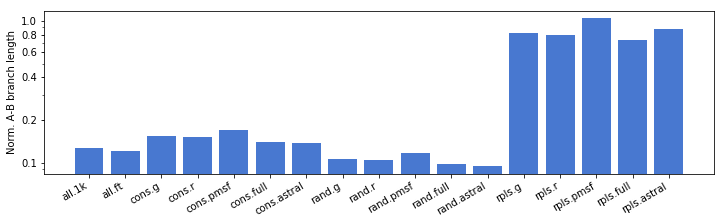

In [32]:
fig = plt.figure(figsize=(12, 3))
data = df['Archaea_height'] / df['radius']
plt.bar(xticks, data)
plt.yscale('log')
yticks = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.yticks(yticks, yticks)
plt.ylabel('Norm. A-B branch length')
plt.xticks(xticks, labels, rotation=30, ha='right');

In [33]:
fig.tight_layout()
fig.savefig('ab.brlen.pdf', bbox_inches='tight')

A-B distance

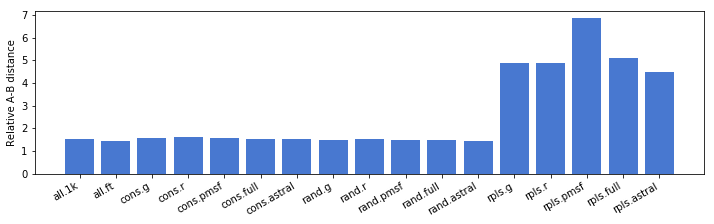

In [34]:
fig = plt.figure(figsize=(12, 3))
data = df['A-B_ratio']
plt.bar(xticks, data)
plt.ylabel('Relative A-B distance')
plt.xticks(xticks, labels, rotation=30, ha='right');

In [35]:
fig.tight_layout()
fig.savefig('ab.dist.pdf', bbox_inches='tight')

Depth and height

In [36]:
df_ = df[df['Eubacteria_height'].notnull()].copy()
df_ = df_[~df_.index.to_series().str.startswith('rpls')]
df_ = df_[~df_.index.to_series().str.endswith('.r')]
df_ = df_[~df_.index.to_series().str.endswith('.astral')]

In [37]:
for x in ('depth', 'height'):
    df_['%s_sum' % x] = sum(df_['%s_%s' % (y, x)] for y in ('Archaea', 'CPR', 'Eubacteria'))
    for y in ('Archaea', 'CPR', 'Eubacteria'):
        df_['%s_%s_norm' % (y, x)] = df_['%s_%s' % (y, x)] / df_['%s_sum' % x]

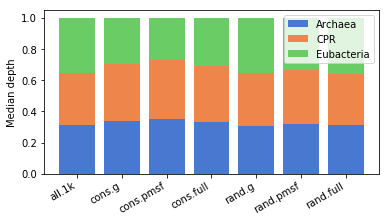

In [38]:
labels = list(df_.index)
xticks = range(len(labels))
fig = plt.figure(figsize=(6, 3))
bottom = [0] * df_.shape[0]
for x in ('Archaea', 'CPR', 'Eubacteria'):
    plt.bar(xticks, df_['%s_depth_norm' % x], bottom=bottom)
    for i in range(len(bottom)):
        bottom[i] += df_['%s_depth_norm' % x][i]
plt.xticks(xticks, labels, rotation=30, ha='right')
plt.ylabel('Median depth')
plt.legend(labels=['Archaea', 'CPR', 'Eubacteria']);

In [39]:
fig.tight_layout()
fig.savefig('depth.pdf', bbox_inches='tight')

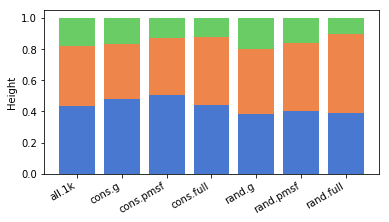

In [40]:
labels = list(df_.index)
xticks = range(len(labels))
fig = plt.figure(figsize=(6, 3))
bottom = [0] * df_.shape[0]
for x in ('Archaea', 'CPR', 'Eubacteria'):
    plt.bar(xticks, df_['%s_height_norm' % x], bottom=bottom)
    for i in range(len(bottom)):
        bottom[i] += df_['%s_height_norm' % x][i]
plt.ylabel('Height')
plt.xticks(xticks, labels, rotation=30, ha='right');

In [41]:
fig.tight_layout()
fig.savefig('height.pdf', bbox_inches='tight')

## Depth distribution

In [42]:
data = []
for site in ('cons', 'rand'):
    for model in ('g', 'pmsf'):
        for clade in ('Archaea', 'CPR', 'Eubacteria'):
            name = '%s.%s' % (site, model)
            tree = trees[name]
            node = tree.lca(tree.subset().intersection(clades[clade]))
            for depth in node.depths:
                data.append([name, site, model, clade, depth])
dfd = pd.DataFrame(data)
dfd.columns = ['tree', 'site', 'model', 'clade', 'depth']
dfd.head()

,tree,site,model,clade,depth
0,cons.g,cons,g,Archaea,0.584646
1,cons.g,cons,g,Archaea,0.545367
2,cons.g,cons,g,Archaea,0.559824
3,cons.g,cons,g,Archaea,0.529409
4,cons.g,cons,g,Archaea,0.588778


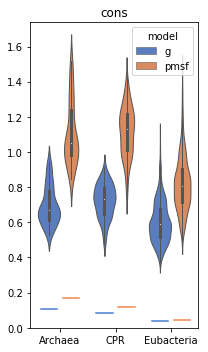

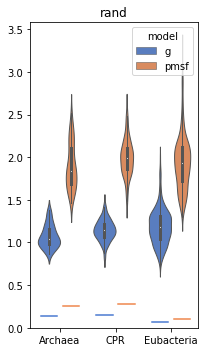

In [43]:
for site in ('cons', 'rand'):
    fig, ax = plt.subplots(figsize=(3, 5))
    sns.violinplot(x='clade', y='depth', hue='model', linewidth=1,
                   data=dfd.query('site == "%s"' % site), ax=ax)
    ax.set_title(site)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    for i, clade in enumerate(('Archaea', 'CPR', 'Eubacteria')):
        h = df['%s_height' % clade]['%s.g' % site]
        ax.plot([i - 0.35, i - 0.05], [h, h], color=sns.color_palette()[0])
        h = df['%s_height' % clade]['%s.pmsf' % site]
        ax.plot([i + 0.05, i + 0.35], [h, h], color=sns.color_palette()[1])
    fig.tight_layout()
    fig.savefig('%s.violin.pdf' % site, bbox_inches='tight')

In [44]:
dfd['radius'] = dfd['tree'].map(radia)
dfd['depth_norm'] = dfd['depth'] / dfd['radius']

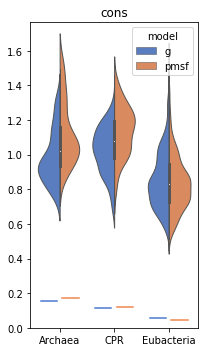

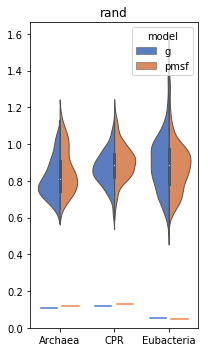

In [45]:
for site in ('cons', 'rand'):
    fig, ax = plt.subplots(figsize=(3, 5))
    sns.violinplot(x='clade', y='depth_norm', hue='model', split=True, linewidth=1,
                   data=dfd.query('site == "%s"' % site), ax=ax)
    ax.set_title(site)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    for i, clade in enumerate(('Archaea', 'CPR', 'Eubacteria')):
        h = df['%s_height' % clade]['%s.g' % site] / radia['%s.g' % site]
        ax.plot([i - 0.35, i - 0.05], [h, h], color=sns.color_palette()[0])
        h = df['%s_height' % clade]['%s.pmsf' % site] / radia['%s.pmsf' % site]
        ax.plot([i + 0.05, i + 0.35], [h, h], color=sns.color_palette()[1])
    fig.tight_layout()
    fig.savefig('%s.norm.violin.pdf' % site, bbox_inches='tight')